# Import the lib

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from PIL import Image
import os

# Implement the compression process

## Define the DCT transformation matrix

Generate the transformation matrix for DCT 
$$
\mathbf{C}_{i,j} = 
\begin{cases}
\sqrt{\frac{1}{N}}, & \text{if } i = 0 \text{（Frist line）} \\
\sqrt{\frac{2}{N}} \cos\left(\frac{(2j + 1) i \pi}{2N}\right), & \text{if } i \geq 1
\end{cases}
$$

In [2]:
def DCT_transform_matrix(N):
    transform_matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if i == 0:
                transform_matrix[i,j] = math.sqrt(1/N)
            else:
                transform_matrix[i,j] = math.sqrt(2/N) * math.cos((2*j+1)*i*math.pi/(2*N))
    return transform_matrix

### Test the DCT_transform_matrix

In [3]:
DCT_transform_matrix(8)

array([[ 0.35355339,  0.35355339,  0.35355339,  0.35355339,  0.35355339,
         0.35355339,  0.35355339,  0.35355339],
       [ 0.49039264,  0.41573481,  0.27778512,  0.09754516, -0.09754516,
        -0.27778512, -0.41573481, -0.49039264],
       [ 0.46193977,  0.19134172, -0.19134172, -0.46193977, -0.46193977,
        -0.19134172,  0.19134172,  0.46193977],
       [ 0.41573481, -0.09754516, -0.49039264, -0.27778512,  0.27778512,
         0.49039264,  0.09754516, -0.41573481],
       [ 0.35355339, -0.35355339, -0.35355339,  0.35355339,  0.35355339,
        -0.35355339, -0.35355339,  0.35355339],
       [ 0.27778512, -0.49039264,  0.09754516,  0.41573481, -0.41573481,
        -0.09754516,  0.49039264, -0.27778512],
       [ 0.19134172, -0.46193977,  0.46193977, -0.19134172, -0.19134172,
         0.46193977, -0.46193977,  0.19134172],
       [ 0.09754516, -0.27778512,  0.41573481, -0.49039264,  0.49039264,
        -0.41573481,  0.27778512, -0.09754516]])

## Perform DCT on the input image block

Perform DCT on the input image block to convert it into the frequency domain, which is conducive to eliminating high-frequency information in the subsequent process.
Its formula is:
$$
 F(u,v) = \sum_{x=0}^{N-1} \sum_{y=0}^{N-1} f(x,y) \cdot C(u,x) \cdot C(v,y)
$$

In the formula：
-  $f(x,y)$ ：The pixel values of the image block
-  $F(u,v)$ ：Frequency domain coefficients
-  $C(u,x)$  和  $C(v,y)$ ：The elements of the DCT transformation matrix
In matrix form, it is expressed as：  
$$
F = T^T \cdot X \cdot T
$$

In [4]:
def dct(block, transform_matrix):
    if len(block.shape) == 3: # If RGB
        dct_blocks = []
        for c in range(block.shape[2]):
            channel_block = block[:,:,c]
            dct_block = np.dot(np.dot(transform_matrix.T, channel_block), transform_matrix)
            dct_blocks.append(dct_block)
        return np.dstack(dct_blocks)
    else: # If grey-scale map
        return np.dot(np.dot(transform_matrix.T, block), transform_matrix)

## Image preprocessing and segmentation

Perform preprocessing on the image, cropping it to multiples of block_size to facilitate subsequent compression. At the same time, distinguish the input image categories and perform centering processing according to the categories.

In [5]:
def preprocess_image(img, block_size = 8):
    color = False
    if len(img.shape) == 3:
        h, w, c = img.shape
        color = True
    else :
        h, w = img.shape
    h = h - h % block_size
    w = w - w % block_size
    img = img[:h, :w]
    blocks = []
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            if color:
                blocks.append(img[i:i+block_size, j:j+block_size] - 128) # The centralization processing of RGB images, with the value range being [-128, 127]
            else:
                blocks.append(img[i:i+block_size, j:j+block_size] - 0.5) # The centralization processing of grayscale images, with the value range being [-0.5, 0.5]
    return blocks, (h, w)

## Define a quantitative matrix

The generation of the luminance quantization table **Q_y** and the chrominance quantization table **Q_c** facilitates the subsequent quantization operations. They dynamically adjust the quantization matrix and have different scaling strategies for different quality values. At the same time, the minimum value is set to 1 to prevent division by zero errors.

In [6]:
def quantitative_matrix(quality = 50, channel = 'y'):
    Q_y = np.array([ # luminance quantization table
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99]
    ])
    Q_c = np.array([# chrominance quantization table
        [17, 18, 24, 47, 99, 99, 99, 99],
        [18, 21, 26, 66, 99, 99, 99, 99],
        [24, 26, 56, 99, 99, 99, 99, 99],
        [47, 66, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99]
    ])

    Q = Q_y if channel == 'y' else Q_c

    # dynamic strategy
    if quality < 50:
        scale = 5000 / quality 
    else:
        scale = 200 - 2 * quality 
    
    Q = np.floor((Q * scale + 50) / 100).astype(int)
    Q = np.clip(Q, 1, None) # Set the minimum value to 1

    return Q

In [7]:
quantitative_matrix()

array([[ 16,  11,  10,  16,  24,  40,  51,  61],
       [ 12,  12,  14,  19,  26,  58,  60,  55],
       [ 14,  13,  16,  24,  40,  57,  69,  56],
       [ 14,  17,  22,  29,  51,  87,  80,  62],
       [ 18,  22,  37,  56,  68, 109, 103,  77],
       [ 24,  35,  55,  64,  81, 104, 113,  92],
       [ 49,  64,  78,  87, 103, 121, 120, 101],
       [ 72,  92,  95,  98, 112, 100, 103,  99]])

## Quantitative method

The DCT coefficients are quantized. In this method, the Q_y quantization table and Q_c quantization table are used for the DCT coefficients of RGB, while the DCT coefficients of grayscale images are only quantized using the Q_y quantization table.

In [ ]:
def quantize(dct_block, Q_y, Q_c = None):
    if Q_c is None:
        return np.round(dct_block / Q_y)
    quantized = np.zeros_like(dct_block)
    quantized[:,:,0] = np.round(dct_block[:,:,0] / Q_y)  # Y
    quantized[:,:,1] = np.round(dct_block[:,:,1] / Q_c)  # Cb
    quantized[:,:,2] = np.round(dct_block[:,:,2] / Q_c)  # Cr
    return quantized

## The conversion function from RGB to YCbCr and from YCbCr to RGB

Realize the mutual conversion between RGB and YCbCr color spaces, separate the visually sensitive brightness from the less-sensitive chroma, and process them separately. The conversion formulas are as follows:   
**RGB to YCbCr:**
$$
Y = 0.299R + 0.587G + 0.114B \\
Cb = -0.1687R - 0.3313G + 0.5B + 128 \\
Cr = 0.5R - 0.4187G - 0.0813B + 128
$$
**YCbCr to RGB:**
$$
R = Y + 1.402 \cdot (Cr - 128) \\
G = Y - 0.34414 \cdot (Cb - 128) - 0.71414 \cdot (Cr - 128) \\
B = Y + 1.772 \cdot (Cb - 128)
$$
In the formula:
 - $Y$: Brightness component, dominant for human eye perception
 - $Cb/Cr$: Color difference signal

In [9]:
def rgb2ycbcr(img):
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    
    y = 0.299 * r + 0.587 * g + 0.114 * b
    cb = -0.1687 * r - 0.3313 * g + 0.5 * b + 128
    cr = 0.5 * r - 0.4187 * g - 0.0813 * b + 128

    return np.dstack((y, cb, cr))

def ycbcr2rgb(ycbcr):
    y = ycbcr[:,:,0]
    cb = ycbcr[:,:,1] - 128
    cr = ycbcr[:,:,2] - 128
    
    r = y + 1.402 * cr
    g = y - 0.34414 * cb - 0.71414 * cr
    b = y + 1.772 * cb
    
    r = np.clip(r, 0, 255)
    g = np.clip(g, 0, 255)
    b = np.clip(b, 0, 255)
    
    return np.dstack((r, g, b))

## Compressing image

![](compress_flow.svg)

In [10]:
def compress_image(image_path, quality=50):
    image = plt.imread(image_path)
    color = False
    if len(image.shape) == 3: 
        image = rgb2ycbcr(image)
        color = True
    trans_matrix = DCT_transform_matrix(8)
    Q_y = quantitative_matrix(quality, 'y')
    Q_c = quantitative_matrix(quality, 'c')


    blocks, shape = preprocess_image(image)
    compressed_blocks = []
    for block in blocks:
        dct_block = dct(block, trans_matrix)
        if color:
            quantize_block = quantize(dct_block, Q_y, Q_c)
        else:
            quantize_block = quantize(dct_block, Q_y)
        compressed_blocks.append(quantize_block)
    return compressed_blocks, shape, (Q_y, Q_c)


# Implement the decompression process

## Dequantize method

The dequantized method formula here is as follows:
$$
r_c = q_c \times S_c
$$
In the formula:
 - $r_c$: The floating-point value after dequantization 
 - $q_c$: The quantified integer value
 - $S_c$: The quantifying step size  
When dealing with an RGB image, the quantized_block passed in has three dimensions. The first dimension is denoted as Q_y, and the remaining dimensions are denoted as Q_c for dequantization. When it is a grayscale image, only use Q_y to dequantize.

In [11]:
def dequantize(quantized_block, Q):
    if len(quantized_block.shape) == 3:
        return quantized_block * np.dstack([Q[0], Q[1], Q[1]])
    return quantized_block * Q[0]

## Invert DCT method

The two-dimensional IDCT formula is as follows:  
$$
f(x,y) = \sum_{u=0}^{N-1} \sum_{v=0}^{N-1} c(u)c(v) F(u,v) \cos\left[\frac{(2x+1)u\pi}{2N}\right] \cos\left[\frac{(2y+1)v\pi}{2N}\right]
$$
In matrix form, it is expressed as：  
$$
F = T \cdot X \cdot T^T
$$


In [12]:
def idct(dct_block, transform_matrix):
    if len(dct_block.shape) == 3:
        idct_blocks=[]
        for c in range(dct_block.shape[2]):
            channel_block =dct_block[:,:,c]
            idct_block = np.dot(np.dot(transform_matrix, channel_block), transform_matrix.T)
            idct_blocks.append(idct_block)
        return np.dstack(idct_blocks)
    else:
        return np.dot(np.dot(transform_matrix, dct_block), transform_matrix.T)

## Decompressing process

![](decompress_flow.svg)

In [13]:
def decompress_image(compressed_blocks, shape, Q, block_size=8):
    transform_matrix = DCT_transform_matrix(8)
    h,w = shape
    color = False
    if len(compressed_blocks[0].shape) == 3:
        reconstructed = np.zeros((h,w,3))
        color = True
    else:
        reconstructed = np.zeros((h,w))
    block_idx = 0
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            dequantized_block = dequantize(compressed_blocks[block_idx], Q)
            block = idct(dequantized_block, transform_matrix)
            if color:
                reconstructed[i:i+block_size, j:j+block_size] = block + 128
            else:
                reconstructed[i:i+block_size, j:j+block_size] = block + 0.5
            block_idx += 1
    if color == True:
        reconstructed = ycbcr2rgb(reconstructed).astype(np.uint8)
    else:
        reconstructed = np.clip(reconstructed, 0, 1)
    return reconstructed



# Simple compression process

In [14]:

def psnr(original, reconstructed):
    if len(original.shape) == 3:
        max_val = 255
    else:
        max_val = 1
    mse = np.mean((original-reconstructed)**2)
    return 100 if mse == 0 else 10*np.log10(max_val/mse)


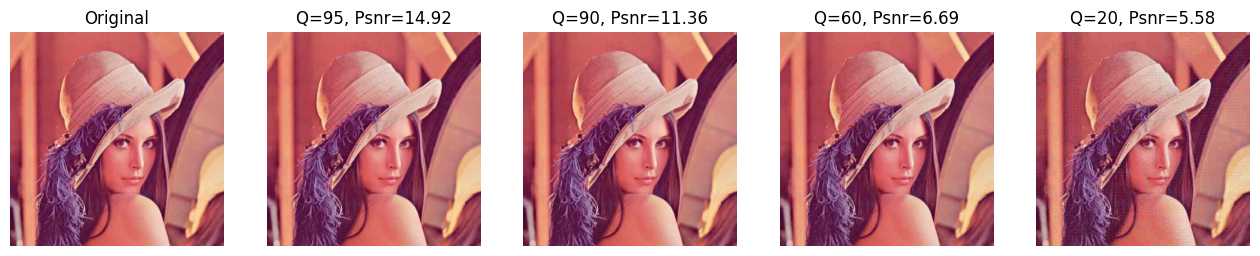

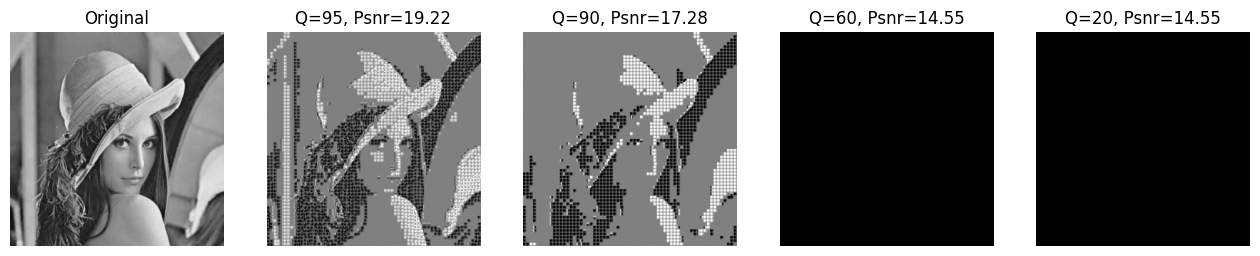

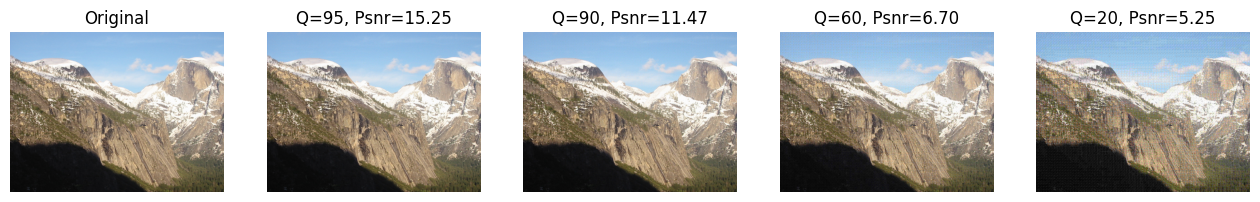

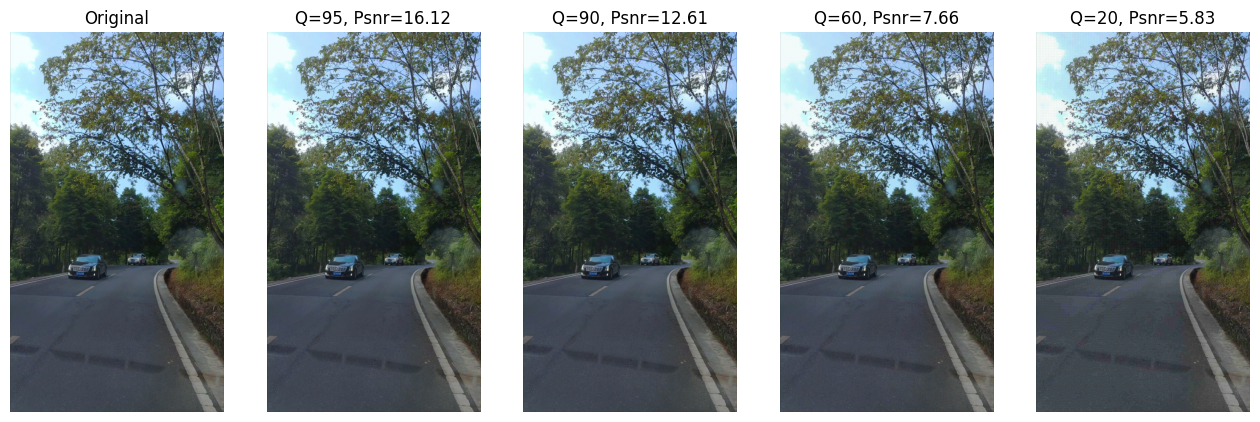

In [15]:
data_dir = 'data'
qualities = [95, 90, 60, 20]
fig_len = len(qualities) + 1
for filename in os.listdir(data_dir):
    image_path = os.path.join(data_dir, filename)
    plt.figure(figsize=(16,8))
    plt.subplot(1,fig_len,1)
    plt.imshow(plt.imread(image_path), cmap='gray')
    plt.title('Original')
    plt.axis('off')
    index = 2
    for q in qualities:
        compressed_blocks, shape, Q = compress_image(image_path, quality=q)
        reconstructed = decompress_image(compressed_blocks, shape, Q)
        p = psnr(plt.imread(image_path), reconstructed)
        plt.subplot(1,fig_len,index)
        plt.imshow(reconstructed, cmap='gray')
        plt.title(f'Q={q}, Psnr={p:.2f}')
        plt.axis('off')
        index += 1
    plt.show()